In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install transformers

In [3]:
!pip install datasets

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


In [5]:
from transformers import pipeline  # Load task-specific pipelines (e.g., image classification, text generation)
from transformers import AutoModel  # Load a base model automatically
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification
# ViTFeatureExtractor: Prepares images (resize, normalize, etc.)
# ViTModel: Vision Transformer that splits the image into patches, embeds them, and processes them via transformer encoder layers to produce a
#feature representation
# ViTForImageClassification: Vision Transformer specialized for image classification
from transformers import TrainingArguments, Trainer  # Configure and run model training
import torch
from torch.utils.data import DataLoader  # Create batched data loaders
from datasets import load_dataset  # Load datasets from Hugging Face
from evaluate import load  # Load evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Compute classification metrics and plot confusion matrix
import tensorflow as tf
import numpy as np

In [6]:
!pip install skillsnetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00


### Data loading

In [7]:
import skillsnetwork
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0RR9EN/LargeData/all_images_sign.zip", overwrite=True)

  0%|          | 0/428 [00:00<?, ?it/s]

Saved to '.'


In [8]:
train_ds = load_dataset('all_images', split='train[:197]')
# Select the first 197 rows of the 'train' split from the 'all_images' dataset

Resolving data files:   0%|          | 0/197 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
test_ds = load_dataset('all_images', split='test[:7]')
# Select the first 7 rows of the 'test' split from the 'all_images' dataset

Resolving data files:   0%|          | 0/197 [00:00<?, ?it/s]

In [10]:
test_ds[:2]

{'image': [<PIL.Image.Image image mode=RGB size=3207x1756>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683>],
 'label': [0, 0]}

In [10]:
# Split training data into training (90%) and validation (10%)
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [12]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 177
})

In [13]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 20
})

In [14]:
train_ds.features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['not_stop', 'stop'])}

**Labels:**

1 - Red light

0 - Green light

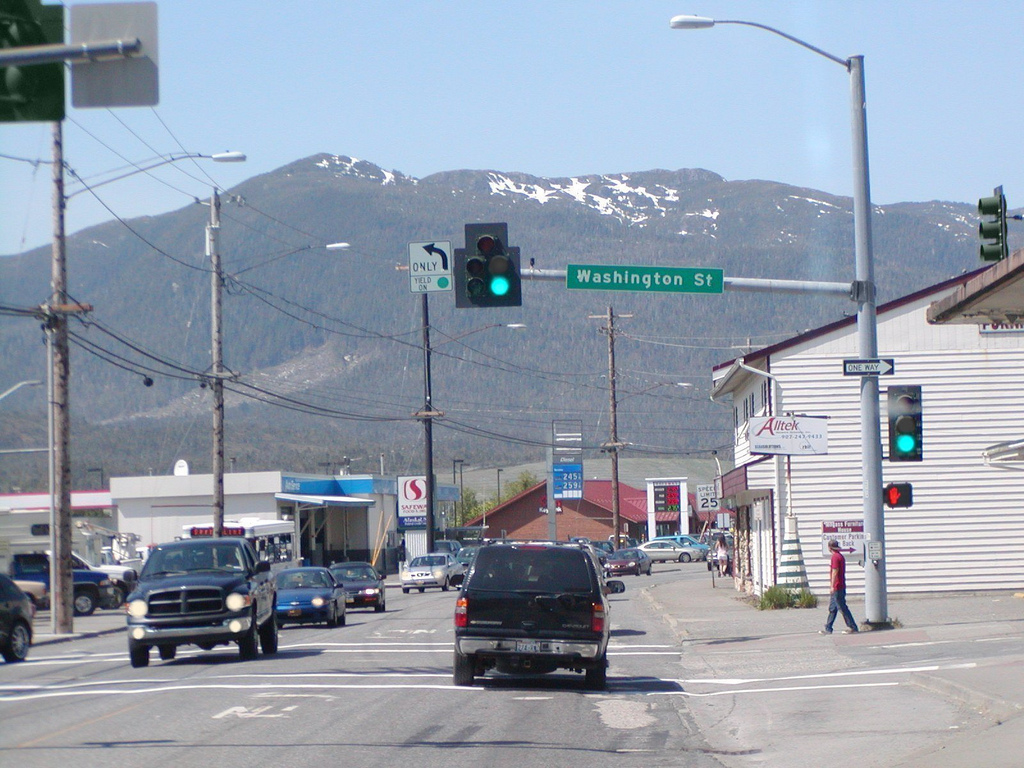

In [15]:
train_ds[6]['image']

In [16]:
train_ds[6]['label']

0

In [11]:
# Create a mapping from class IDs to label names (0 - Green light, 1 - Red light)
id2label = {id: label for id, label in enumerate(train_ds.features['label'].names)}

# Create the reverse mapping from label names to class IDs
label2id = {label: id for id, label in id2label.items()}

id2label

{0: 'not_stop', 1: 'stop'}

###Data Preparation

**Applied transformations:**

CenterCrop: Crops the image at the center to a specified size. This emphasizes the main subject of the image and removes unnecessary edges.

Compose: Chains multiple transformations to be applied sequentially, simplifying preprocessing pipelines.

Normalize: Adjusts pixel values using a specified mean and standard deviation. Normalization ensures that input features are on a consistent scale, which helps the model converge faster and learn more effectively.

RandomHorizontalFlip: Randomly flips the image horizontally. Introduces variability in the dataset and prevents the model from overfitting to specific orientations.

RandomResizedCrop: Randomly crops a portion of the image and resizes it to a fixed size. Encourages the model to learn features from different parts and scales of the image.

Resize: Resizes the image to a fixed size. Ensures all images have the same dimensions, which is required by most deep learning models.

ToTensor: Converts the image to a PyTorch tensor (multi-dimensional array) that can be processed by neural networks.

In [13]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    RandomRotation,
                                    ToTensor)

In [14]:
# Convert the size stored as a dictionary to a tuple for use in transformations
size = (feature_extractor.size["height"], feature_extractor.size["width"])

# Normalization: adjust pixel values using the dataset's mean and standard deviation
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# ----------------------
# Transformation pipelines
# ----------------------

# Transformations applied to training data
_train_transforms = Compose(
    [
        RandomResizedCrop(size),      # Randomly crop and resize image; improves model generalization
        RandomHorizontalFlip(0.10),   # Flip image horizontally with 10% probability to increase diversity
        RandomVerticalFlip(0.10),     # Flip image vertically with 10% probability
        RandomRotation(0.5),          # Rotate image by up to 0.5 degrees; adds rotational invariance
        ToTensor(),                   # Convert image to a PyTorch tensor
        normalize,                     # Normalize pixel values
    ]
)

# Transformations applied to validation data
_val_transforms = Compose(
    [
        Resize(size),                  # Resize image to model's expected input size
        CenterCrop(size),              # Crop the center region of the image
        ToTensor(),                    # Convert image to a PyTorch tensor
        normalize,                     # Normalize pixel values
    ]
)

# Convert images to RGB and apply training transformations
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Convert images to RGB and apply validation transformations
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [15]:
# Apply the transformations only when accessing the images from the dataset
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

### Feature extractor selection

In [12]:
# Use the feature extractor from the ViT model pretrained on ImageNet-21k
# (a dataset with ~14 million images across ~21,000 classes)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

### Model selection

In [1]:
# Pretrained ViT model on ImageNet-21k, configured for 2 labels
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

NameError: name 'ViTForImageClassification' is not defined

### Training parameters

In [17]:
# Training configuration parameters
args = TrainingArguments(
    f"test-image",                   # Output folder to save model checkpoints
    save_strategy="epoch",            # Save the model at the end of each epoch
    eval_strategy="epoch",            # Evaluate the model at the end of each epoch
    learning_rate=2e-5,               # Learning rate
    per_device_train_batch_size=10,   # Number of images processed simultaneously per GPU during training
    per_device_eval_batch_size=4,     # Number of images processed simultaneously per GPU during evaluation
    num_train_epochs=2,               # Number of epochs; the model will see the full training set twice
    weight_decay=0.01,                # Regularization to prevent weights from growing too large (reduces overfitting)
    load_best_model_at_end=True,      # Load the best model at the end of training
    metric_for_best_model="accuracy", # Metric used to evaluate the best model
    logging_dir='logs',               # Folder to store training logs and metrics
    remove_unused_columns=False,      # Do not remove columns that are not used in training
)

In [18]:
metric = load("accuracy")

def compute_metrics(eval_pred):  # Receives a tuple of predictions and labels
    predictions, labels = eval_pred  # Extract predictions and true labels
    predictions = np.argmax(predictions, axis=1)  # Take the index of the highest logit as the predicted class
    return metric.compute(predictions=predictions, references=labels)  # Compute accuracy

In [19]:
# Function to group images into batches
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # Stack image tensors into a batch, e.g., (4, 3, 224, 224) -> 4 images, 3 channels (RGB), 224x224 pixels
    labels = torch.tensor([example["label"] for example in examples])
    # Stack labels into a tensor, e.g., [2, 0, 1, 3] for a batch of 4
    return {"pixel_values": pixel_values, "labels": labels}

# Create a DataLoader to send data to the model in batches during training
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)
# Each batch contains 4 images

# Example batch
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):  # Process only if the value is a tensor
        print(k, v.shape)  # Print the key and the tensor's shape

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [20]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

### Training

In [21]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.622638,0.800000
2,No log,0.582963,0.850000


TrainOutput(global_step=36, training_loss=0.6254862149556478, metrics={'train_runtime': 883.3415, 'train_samples_per_second': 0.401, 'train_steps_per_second': 0.041, 'total_flos': 2.743216432356557e+16, 'train_loss': 0.6254862149556478, 'epoch': 2.0})

In [22]:
outputs = trainer.predict(test_ds)

### Evaluation

In [29]:
print(outputs.metrics)

{'test_loss': 0.5890647172927856, 'test_accuracy': 1.0, 'test_runtime': 4.8606, 'test_samples_per_second': 1.44, 'test_steps_per_second': 0.411}


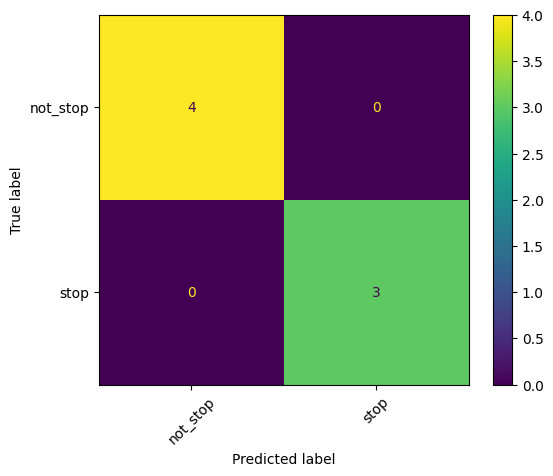

In [34]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [36]:
y_true

array([0, 0, 0, 0, 1, 1, 1])

In [35]:
y_pred

array([0, 0, 0, 0, 1, 1, 1])